# Trigger efficiency extraction from di-muon exclusive sample

## Setting the environment.

In [1]:
#version 28-APR-2023
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np
np.random.seed(0) #fix the random seed to get deterministic results

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

## Utility functions

We will generate toy MC events for $\mu^{+}$ and $\mu^{-}$. For each particle the following information is generated:

* momentum ($p$), polar angle $\theta$, trigger decision $trg$, smeared momentum values $p_{smeared}$

First we prepare relevant functions:

* ```
momentum_acceptance(p)
``` - function accepts a matrix of momentum values and returns matrix of acceptance values

* ```
theta_acceptance(theta)
``` - function accepts a matrix of theta values and returns matrix of acceptance values

* ```
generate_events(nEvents, mean_momentum)
``` - function accepts number of events, and mean momentum and return a matrix of simulated events with two columns for each event property:

```
p, theta, phi, trg_decision, p_smeared
```

In [2]:
def momentum_acceptance(p):
    
    acc = np.full_like(p, 1.0)
    acc = np.where(p<0.5, 0.0, acc)
    acc = np.where((p>0.5)*(p<1.5), p - 0.5, acc)
    return acc

def theta_acceptance(theta):
    
    acc = np.full_like(theta, 0.8)
    acc = np.where(theta<0.5, 0.0, acc)
    acc = np.where(theta>np.pi-0.5, 0.0, acc)
    return acc
    

def generate_events(nEvents, mean_momentum):
    
    #data shape is: nEvents rows, two columns for each muon
    data_shape = (nEvents, 2)
    
    p = np.random.exponential(mean_momentum, data_shape)
    cosTheta = np.random.uniform(-1,1, data_shape)
    theta = np.arccos(cosTheta)
    phi = np.random.uniform(0, 2.0*np.pi, data_shape)
    
    mom_acc = momentum_acceptance(p)
    theta_acc = theta_acceptance(theta)
    total_acc = mom_acc*theta_acc
    trg_decision = np.random.uniform(0,1, data_shape)<total_acc
    
    p_smeared = np.random.normal(p,0.15)
    p_smeared = np.abs(p_smeared)
    
    events = np.column_stack((p, theta, phi, trg_decision, p_smeared) )
    return events

### Generate $nEvents$ of muon pairs, with $mean\_momentum$

In [3]:
%%time
nEvents = 10000
mean_momentum = 2

events = generate_events(nEvents, mean_momentum)

print(colored("Shape of the data:","blue"),events.shape)
print(colored("Columns names:","blue"), "p, theta, phi, trg_decision, p_smeared")
print(colored("Each columns is duplicated for mu+ and mu-!", "red"))

Shape of the data: (10000, 10)
Columns names: p, theta, phi, trg_decision, p_smeared
Each columns is duplicated for mu+ and mu-!
CPU times: user 2.59 ms, sys: 3.68 ms, total: 6.27 ms
Wall time: 5.49 ms


## Control histograms. 

Every time we analyze any data we start with simple plots to check it the data does not have major issues (knows as bugs)

Matplotlib histograms are more convenient here, as we do not have to wrtite loops over the events for them.

When we plot the histograms for $p$ before and after the trigger decision we alco keep the counts in mmentum bins:

```Python
counts_MuPlus, _, _ = axes[0,0].hist(events[:,0], bins = bins, label="$\mu^{+}$")
```

for the second muon we do not make a plot, just calculate the event counts in bins:

```Python
counts_MuPlus_trg2, _ = np.histogram(events_passing_trg1[:,0], bins = bins)
```


The event counts will be needed for efficiency calculations.

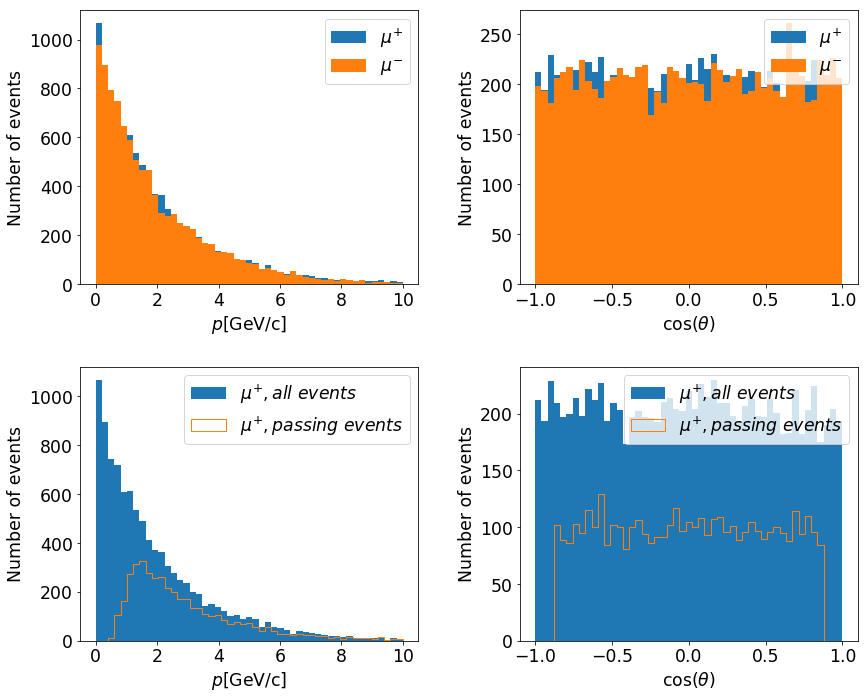

In [4]:
fig, axes = plt.subplots(2,2, figsize=(12, 12))

#Histogram for momentum
minP = 0
maxP = 10.
nBins = 50
bins = np.linspace(minP, maxP, nBins)

muPlus_theta_idx = 2
muMinus_theta_idx = 3

muPlus_trg_idx = 6
muMinus_trg_idx = 7

counts_MuPlus, _, _ = axes[0,0].hist(events[:,0], bins = bins, label="$\mu^{+}$")
counts_MuMinus, _, _ = axes[0,0].hist(events[:,1], bins = bins, label="$\mu^{-}$")
axes[0,0].set_xlabel(r"$p$[GeV/c]")
axes[0,0].set_ylabel("Number of events")
axes[0,0].legend(loc="upper right");

bins = np.linspace(-1, 1, nBins)
axes[0,1].hist(np.cos(events[:,muPlus_theta_idx]), bins = bins, label="$\mu^{+}$")
axes[0,1].hist(np.cos(events[:,muMinus_theta_idx]), bins = bins, label="$\mu^{-}$")
axes[0,1].set_xlabel(r"$\cos(\theta)$")
axes[0,1].set_ylabel("Number of events")
axes[0,1].legend(loc="upper right");

events_passing_trg1 = events[events[:,muPlus_trg_idx]>0]
events_passing_trg2 = events[events[:,muMinus_trg_idx]>0]
bins = np.linspace(minP, maxP, nBins)
axes[1,0].hist(events[:,0], bins = bins, label="$\mu^{+}, all\ events$")
counts_MuPlus_trg1, _, _ = axes[1,0].hist(events_passing_trg1[:,0], bins = bins, histtype="step", label="$\mu^{+}, passing\ events$")
counts_MuPlus_trg2, _ = np.histogram(events_passing_trg1[:,0], bins = bins)
#axes[1,0].hist(events[:,0], bins = bins, label="$\mu^{+}, all\ events$")
axes[1,0].set_xlabel(r"$p$[GeV/c]")
axes[1,0].set_ylabel("Number of events")
axes[1,0].legend(loc="upper right");

bins = np.linspace(-1, 1, nBins)
axes[1,1].hist(np.cos(events[:,2]), bins = bins, label="$\mu^{+}, all\ events$")
axes[1,1].hist(np.cos(events_passing_trg1[:,2]), bins = bins, histtype="step", label="$\mu^{+}, passing\ events$")
#axes[1,1].hist(np.cos(events[:,2]), bins = bins, label="$\mu^{+}, all\ events$")
axes[1,1].set_xlabel(r"$\cos(\theta)$")
axes[1,1].set_ylabel("Number of events")
axes[1,1].legend(loc="upper right");

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3, hspace=0.3) 

## The tag and probe event counts in bins of momentum

In [5]:
bins = np.linspace(minP, maxP, nBins)
#pT of the second muon if the first one fired the trigger
tag_counts_muPlus, _ = np.histogram(events_passing_trg1[:,1], bins = bins)

#pT of the first muon if the second one fired the trigger
tag_counts_muMinus, _ = np.histogram(events_passing_trg2[:,0], bins = bins)

events_passing_trg1_trg2 = events_passing_trg1[events_passing_trg1[:,7]>0]

#pT of the second muon if the first one fired the trigger
probe_counts_muPlus, _ = np.histogram(events_passing_trg1_trg2[:,1], bins = bins)

#pT of the first muon if the second one fired the trigger
probe_counts_Minus, _ = np.histogram(events_passing_trg1_trg2[:,0], bins = bins)

## Efficiency calculation

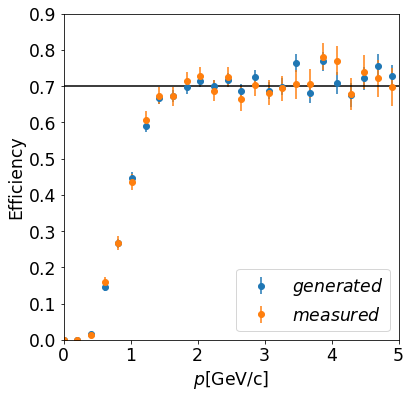

In [6]:
fig, axis = plt.subplots(1,1, figsize=(6, 6))

eff_MC = (counts_MuPlus_trg1 + counts_MuPlus_trg2)/(counts_MuPlus + counts_MuPlus)
eff_MC_uncertainty = np.sqrt(eff_MC*(1-eff_MC)/(counts_MuPlus + counts_MuPlus))

eff_TP = (probe_counts_muPlus + probe_counts_Minus)/(tag_counts_muPlus + tag_counts_muMinus)
eff_TP_uncertainty = np.sqrt(eff_TP*(1-eff_TP)/(tag_counts_muPlus + tag_counts_muMinus))

#plot the efficiency values at the middle of the momentum bins
x = bins[:-1] + (bins[1] - bins[0])/2.0

axis.errorbar(bins[:-1], eff_MC, yerr=eff_MC_uncertainty, fmt='o', label="$generated~\epsilon$")
axis.errorbar(bins[:-1], eff_TP, yerr=eff_TP_uncertainty, fmt="o", label="$measured~\epsilon$")

axis.plot([0,10], [0.7, 0.7], "black")
axis.set_xlim([0, 5])
axis.set_ylim([0, 0.9])
axis.set_xlabel(r"$p$[GeV/c]")
axis.set_ylabel("Efficiency")
axis.legend(loc="lower right");